In [10]:
#evaluate ekman pumping in easterlies experiment

In [11]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [12]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44195 Dashboard: /proxy/38983/status,Cluster Workers: 4 Cores: 4 Memory: 100.00 GiB


In [13]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [14]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [15]:
ee = explore.ExperimentExplorer(session=master_session, experiment='01deg_jra55v13_ryf9091')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [16]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [17]:
expt='01deg_jra55v140_iaf'

tmask = cc.querying.getvar(expt,'ht',master_session,n=1).sel(yt_ocean=slice(-90,-55))
tmask.load()
print(tmask.shape)

ht = cc.querying.getvar(expt,'ht',master_session,n=1).sel(yt_ocean=slice(-90,-55))
ht.load()
print(ht.shape)

variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xt_ocean.load()
print(xt_ocean.shape)

variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
yt_ocean.load()
print(yt_ocean.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

variable='geolon_t'
geolon_t = cc.querying.getvar(expt,variable,master_session, n=-1)
geolon_t.load()
print(geolon_t.shape)

variable='geolat_t'
geolat_t = cc.querying.getvar(expt,variable,master_session, n=-1)
geolat_t.load()
print(geolat_t.shape)

variable='geolon_c'
geolon_c = cc.querying.getvar(expt,variable,master_session, n=-1)
geolon_c.load()
print(geolon_c.shape)

variable='geolat_c'
geolat_c = cc.querying.getvar(expt,variable,master_session, n=-1)
geolat_c.load()
print(geolat_c.shape)

variable='xu_ocean'
xu_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xu_ocean.load()
print(xu_ocean.values)

variable='yu_ocean'
yu_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
yu_ocean.load()
print(yu_ocean.shape)

variable='area_u'
area_u = cc.querying.getvar(expt,variable,master_session, n=-1)
area_u.load()
print(area_u.shape)

variable='dxt'
dxt = cc.querying.getvar(expt,variable,master_session, n=-1)
dxt.load()
print(dxt.shape)

variable='dyt'
dyt = cc.querying.getvar(expt,variable,master_session, n=-1)
dyt.load()
print(dyt.shape)

(584, 3600)
(584, 3600)
(3600,)
(2700,)
(2700, 3600)
(2700, 3600)
(2700, 3600)
(2700, 3600)
(2700, 3600)
[-279.9 -279.8 -279.7 ...   79.8   79.9   80. ]
(2700,)
(2700, 3600)
(2700, 3600)
(2700, 3600)


In [18]:
# these are the values used by MOM5
Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m

f = 2 * Ω * np.sin(np.deg2rad(geolat_c)) # convert lat in radians
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

In [19]:
print(f.shape)

(2700, 3600)


In [20]:
start = '1958-01-01 00:00:00'
end = '2019-01-01 00:00:00'

expt='01deg_jra55v140_iaf_cycle2'

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-50.04)

In [21]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

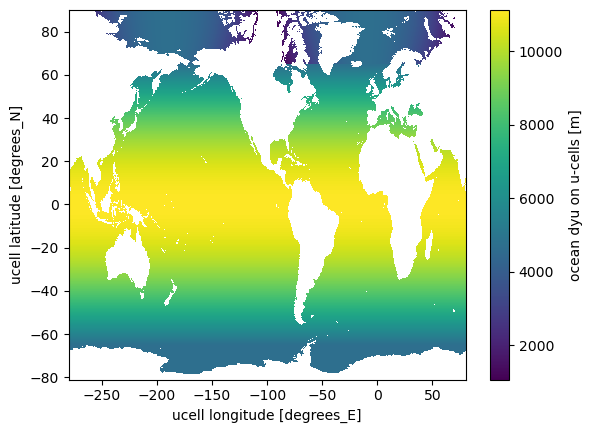

In [23]:
#dx cells are nan on all land in this expt
dyu = cc.querying.getvar(expt, 'dyu', master_session, n=1)
dyu.plot.pcolormesh()

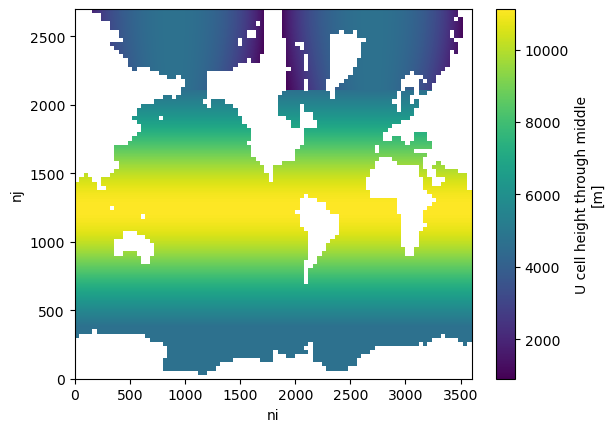

In [27]:
#this ryf expt has dx,dy values on coast
dyu = cc.querying.getvar('01deg_jra55v13_ryf9091', 'dyu', master_session, n=1)
dyu.plot.pcolormesh()

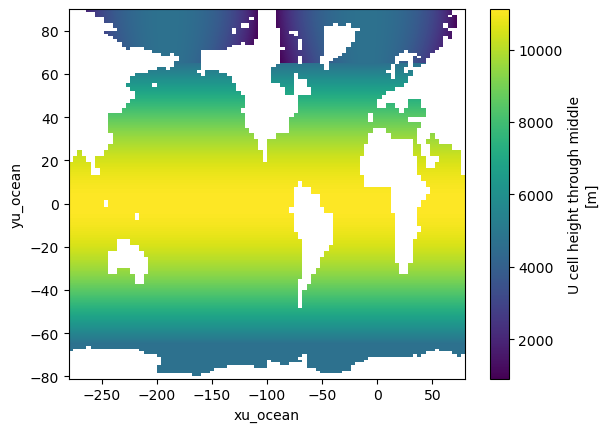

In [28]:
dyu['ni'] = xu_ocean.values
dyu['nj'] = yu_ocean.values
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu.plot.pcolormesh()

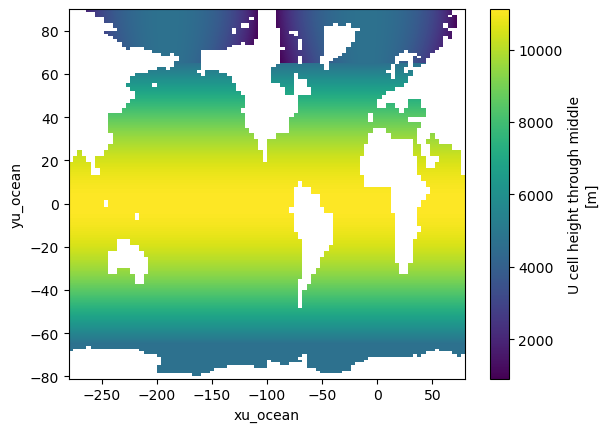

In [29]:
dxu = cc.querying.getvar('01deg_jra55v13_ryf9091', 'dxu', master_session, n=1)
dxu['ni'] = xu_ocean.values
dxu['nj'] = yu_ocean.values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu.plot.pcolormesh()

In [30]:
dyu = dyu.sel(yu_ocean=lat_slice)
dxu = dxu.sel(yu_ocean=lat_slice)

In [31]:
tau_x = cc.querying.getvar(expt, 'tau_x', master_session, frequency='1 monthly',start_time=start, end_time=end)
tau_x = tau_x.sel(time=slice(start,end)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(expt, 'tau_y', master_session, frequency='1 monthly',start_time=start, end_time=end)
tau_y = tau_y.sel(time=slice(start,end)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [32]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

In [33]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman = curl_tauf/rho0*s_day

# mask land:
ekman = ekman.where(ekman!=0)

In [36]:
# Change coords to t grid:
ekman['xu_ocean'] = ht['xt_ocean'].values
ekman['yu_ocean'] = ht['yt_ocean'].values
ekman = ekman.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

In [37]:
ekman

<xarray.DataArray (time: 61, yt_ocean: 665, xt_ocean: 3600)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.23556601,  0.2127295 ,  0.20166107, ...,  0.24160725,
          0.25750075,  0.25454061],
        [ 0.25519882,  0.21556888,  0.19575414, ...,  0.28657493,
          0.29416213,  0.28174575],
        [ 0.27636809,  0.23769668,  0.20346315, ...,  0.31483391,
          0.31913367,  0.30166602]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.0279839 ,  0.04642948,  0.04402354, ..., -0.03511976,
         -0.03955473, -0.00660539],
        [ 0.02496308,  0.03166636,  0.03956479, ..., -0.03497161,
         -0.04288012, -0.00169748],
        [ 0.01457371, -0.01115092,  0.00771403, ..., -0.05925606,
         -0.04385326,  0.01526395]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00732253, -0.02646928, -0.03956553, ...,  0.12159519,
          0.07865837,  0.02427332],
        [ 0.01139272, -0.0244922 , -0.02703924, ...,  0.14013367,
          0.10548591,  0.06553079],
        [ 0.01350867, -0.00669633,  0.00799308, ...,  0.15089593,
          0.1223875 ,  0.07319501]]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.22 -50.16 -50.09
  * time      (time) datetime64[ns] 1958-12-31 1959-12-31 ... 2018-12-31
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    TLON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -50.09 -50.09 -50.09
    ULON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -50.06 -50.06 -50.06

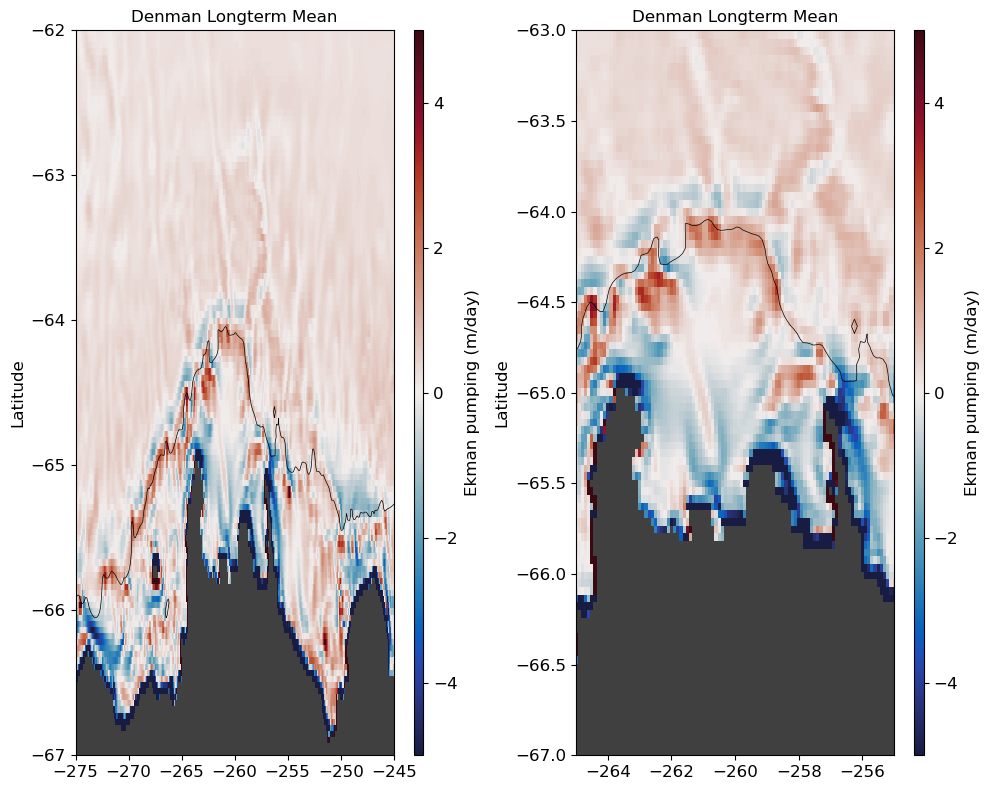

In [39]:
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')
plt.title('Denman Longterm Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-67,-62)
plt.xlim(-275,-245)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(1,2,2)
plt.gca().patch.set_color('.25')
plt.title('Denman Longterm Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-67,-63)
plt.xlim(-265,-255)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.tight_layout()

#figure_path = figdir+'/Ekman_pumping_Amundsen_zoom_yrs_2050_2164.png'
#plt.savefig(figure_path, dpi=250,bbox_inches='tight', pad_inches=0.1,facecolor='white')


In [43]:
#var.where((var.lat<5) & (var.lat>-5) & (var.lon>190) & (var.lon<240),drop=True

tmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
tmask = tmask.where(~xr.ufuncs.isfinite(tmask.where(yt_ocean>-60)))
tmask = ~xr.ufuncs.isnan(tmask).to_dataset(name='tmask')

#plt.xlim([-265,-254])
den_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
den_mask = den_mask.where(~xr.ufuncs.isfinite(den_mask.where(yt_ocean>-60)))
den_mask=den_mask.where(~xr.ufuncs.isfinite(den_mask.where(xt_ocean<-265)))
den_mask=den_mask.where(~xr.ufuncs.isfinite(den_mask.where(xt_ocean>-254)))
den_mask = ~xr.ufuncs.isnan(den_mask).to_dataset(name='den_mask')

den_mask

<xarray.Dataset>
Dimensions:   (xt_ocean: 3600, yt_ocean: 665)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.22 -50.16 -50.09
Data variables:
    den_mask  (yt_ocean, xt_ocean) bool dask.array<chunksize=(540, 720), meta=np.ndarray>

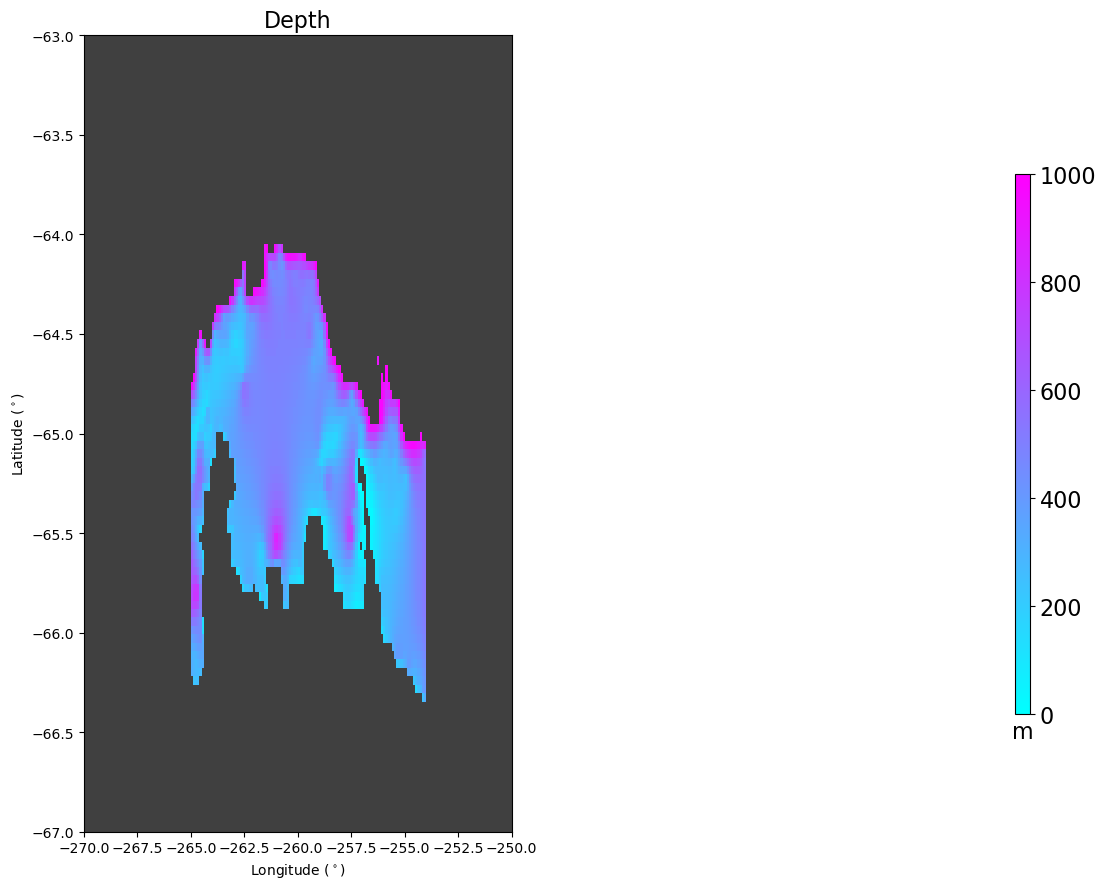

In [44]:
fig = plt.figure(figsize=(10, 9))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')

p1 = ht.where(den_mask.den_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=0, vmax=1000, add_colorbar=False, cmap=plt.cm.cool, extend='both')

plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-63])
plt.xlim([-270,-250])
plt.title('Depth',fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('m',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

In [46]:
#integrate Ekman pumping on the coast
#mask shelf regions
#cstmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>300)))
#cstmask = cstmask.where(~xr.ufuncs.isfinite(cstmask.where(yt_ocean>-63)))
#cstmask = ~xr.ufuncs.isnan(cstmask).to_dataset(name='cstmask')
#cstarea=area_t.where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_shelf=(ekman*area_t).where(den_mask.den_mask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_shelf

<xarray.DataArray (time: 61)>
array([-5.25343887e+10, -5.17883513e+10, -5.65358602e+10, -5.68049198e+10,
       -5.20191378e+10, -4.56701314e+10, -7.51390231e+10, -6.56196807e+10,
       -5.05729718e+10, -6.07912118e+10, -5.47153085e+10, -6.68569233e+10,
       -5.94614970e+10, -7.26115953e+10, -6.78370314e+10, -5.11529103e+10,
       -5.71859873e+10, -7.38753249e+10, -6.58134775e+10, -4.70033321e+10,
       -4.92633818e+10, -6.49178626e+10, -7.37013780e+10, -3.73981306e+10,
       -3.78784308e+10, -5.60557317e+10, -4.75203074e+10, -5.29175952e+10,
       -5.16822899e+10, -5.81983781e+10, -7.11645990e+10, -6.12401532e+10,
       -5.56332050e+10, -5.56958113e+10, -3.93070784e+10, -3.87453451e+10,
       -6.53234441e+10, -5.06515089e+10, -6.01329969e+10, -5.29300463e+10,
       -4.21014728e+10, -5.51115010e+10, -6.06064769e+10, -4.78528803e+10,
       -5.12691803e+10, -4.72739214e+10, -4.19715963e+10, -3.98849412e+10,
       -4.08252444e+10, -6.47115338e+10, -3.14887326e+10, -4.79838542e+10,
       -4.94244648e+10, -4.22321981e+10, -3.70793959e+10, -4.67134517e+10,
       -6.30010374e+10, -4.32438718e+10, -4.71087632e+10, -4.42299508e+10,
       -5.40923708e+10])
Coordinates:
  * time     (time) datetime64[ns] 1958-12-31 1959-12-31 ... 2018-12-31

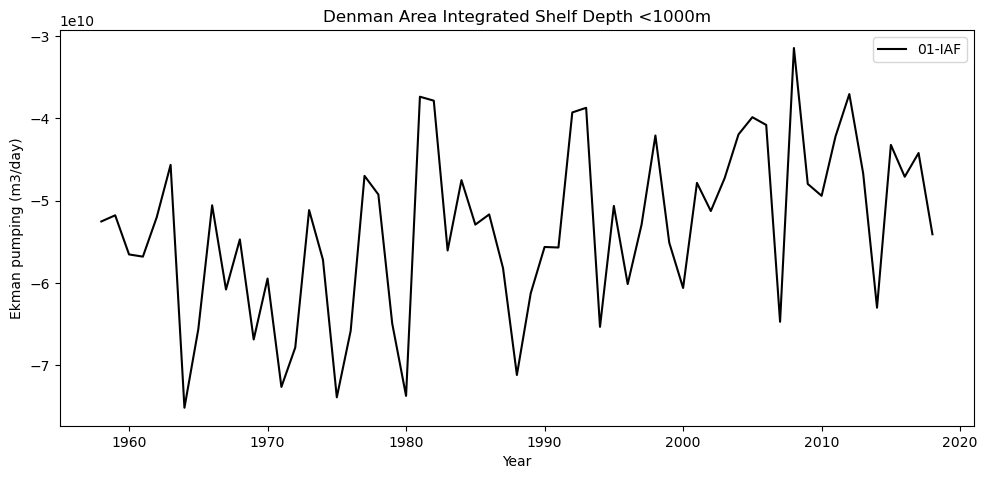

In [48]:
myr=36 #annual means start in 1958, seasonal in 59
yrs=np.arange(1958,2019,1)

fig = plt.figure(figsize=(10, 9))

plt.subplot(211)
plt.plot(yrs,ekman_shelf,linestyle='-',color='k',label='01-IAF',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Ekman pumping (m3/day)')
plt.xlabel('Year')
#plt.xlim([-75,85])
plt.title('Denman Area Integrated Shelf Depth <1000m')
plt.legend(fontsize=10)

plt.tight_layout()